$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Weather Crime Investigation using Dr. Anderson's SCD NNs

## *Amber Lee*

### Overview:

### Investigation of various hidden layer structures on new weekly aggregated weather/crime data

*NOTE- Not all parts of this investigation are documented here.  For example, while looking for various hidden structures, I tried various number of weather inputs.   The best correlations were found using avg bulb temp, dew pt, and humidity.  Wind speed seems to add noise to the model.*

## Required Code

Download [nn2.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/nn2.tar) that was used in lecture and extract its contents, which are

* `neuralnetworks.py`
* `scaledconjugategradient.py`
* `mlutils.py`

In [1]:
import mlutils as ml
import neuralnetworks as nn
import scaledconjugategradient as sc
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint 
import time

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

### trainNNs
The trainNNs function was fairly straightforward and follows the outlined algorithm that Dr. Anderson provided.  The trickiest part was figuring out how to pass the number of elements in T to the Classifier constructor.   len(np.unique(T)) worked well to solve this.   We used RMSE to calculate performance on the linear network and a sum of the fraction of errors for the classification network.

In [2]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify=False):
    result = []
    
    for hidden in hiddenLayerStructures:
        
        train_performance = []
        test_performance = []
        total_collection = []
        
        start_time = time.time()
        
        for n in range(numberRepetitions):
            
            Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T, (trainFraction, 1-trainFraction), classify)
            
            if classify:
                
                nnet = nn.NeuralNetworkClassifier(X.shape[1], hidden, len(np.unique(T))) #need to calculate output layer
                nnet.train(Xtrain, Ttrain, numberIterations)
                
                Ytrain = nnet.use(Xtrain)
                Ytest = nnet.use(Xtest)
                
                train_performance.append((np.sum(Ytrain != Ttrain)/len(Ttrain)))
                test_performance.append((np.sum(Ytest != Ttest)/len(Ttest)))

            else:
                nnet = nn.NeuralNetwork(X.shape[1], hidden, T.shape[1])
                nnet.train(Xtrain, Ttrain, numberIterations)
            
                Ytrain = nnet.use(Xtrain)
                Ytest = nnet.use(Xtest)
                
                train_performance.append(np.sqrt(np.mean((Ytrain-Ttrain)**2)))
                test_performance.append(np.sqrt(np.mean((Ytest-Ttest)**2)))
            
        end_time = time.time()
        total_time = end_time - start_time
            
        total_collection.append(hidden) 
        total_collection.append(train_performance)
        total_collection.append(test_performance)
        total_collection.append(total_time)
            
        result.append(total_collection)
        
    return result

In [3]:
def summarize(results):
    summary = []
    
    for structure in results:
        structure_summary = []
        
        for index, value in enumerate(structure):
            if (index == 0): #hidden layer
                structure_summary.append(value)
            elif (index == 3): #total time
                structure_summary.append(value)
            #the first time we hit this else we are averaging train error
            #the second time we are averaging test error
            else:
                total = 0
                for rmse in value:
                    total += rmse
                structure_summary.append(total/len(value))
        
        summary.append(structure_summary)
    
    return summary

In [4]:
def bestNetwork(summary):          
    #google search for a cool python solution led me to this tutorial. 
    #https://dbader.org/blog/python-min-max-and-nested-lists
    #python is rad
    return min(summary, key=lambda x: x[2])

In [5]:
def scatterPlotCrimes(district, hidden, numIters, Tc, Ttest, Ytest):
    
    print('DISTRICT {}'.format(district))
    print('Hidden Layer Structure: {0}, Number Iterations: {1}'.format(hidden, numIters))
    
    col = ['Homicide', 'Robbery','Battery', 'Assault', 'Burglary', 'Theft', 'Motor Vehicle Theft', 'Weapons Violation']
    xAxis = 'dry'
    plt.figure(figsize=(18,25))
    
    for i in range(len(col)):
        
        r = np.corrcoef(Ttest[:,i], Ytest[:,i])[1:,0]
        title = col[i], " R = ", r
        plt.subplot(4,2,i+1)
        axes = plt.gca()
        m = np.max(Tc5[:,i]) + 1
        axes.set_xlim(None, m)
        axes.set_ylim(None, m)
        plt.scatter(Ttest[:,i], Ytest[:,i], alpha=0.25)
        plt.plot([0,m], [0,m], 'r', linewidth=2)
        plt.xlabel('actual')
        plt.ylabel('predicted')
        plt.title(title)
        
    plt.show() 



In [6]:
def plotAllResults(district, hidden, numIters, Tc, Ttest, Ytest):
    
    print('DISTRICT {}'.format(district))
    print('Hidden Layer Structure: {0} Number Iterations: {1}'.format(hidden, numIters))

    plt.figure(figsize = (10, 10))
    axes = plt.gca()
    m = np.max(Tc + 1)
    axes.set_xlim(0, m)
    axes.set_ylim(0, m)
    plt.scatter(Ttest[:,0], Ytest[:,0], alpha=0.50, label= 'Homicide')
    plt.scatter(Ttest[:,1], Ytest[:,1], alpha=0.50, label= 'Battery')
    plt.scatter(Ttest[:,3], Ytest[:,3], alpha=0.50, label= 'Assault')
    plt.scatter(Ttest[:,4], Ytest[:,4], alpha=0.50, label= 'Burglary')
    plt.scatter(Ttest[:,5], Ytest[:,5], alpha=0.50, label= 'Theft')
    plt.scatter(Ttest[:,6], Ytest[:,6], alpha=0.50, label= 'MotorVehicleTheft')
    plt.scatter(Ttest[:,7], Ytest[:,7], alpha=0.50, label= 'Weapons Violation')

    plt.plot([0,m], [0,m], 'r', linewidth=1)
    plt.legend()
    plt.show();

In [7]:
def loadWeatherData(file, numWeatherInputs):
    
    f = open(file, "r")
    
    data = np.loadtxt(f, delimiter=',', usecols=1+np.arange(13))
    
    targetColumns = np.arange(5, 13)
    
    if (numWeatherInputs != 3):
        XColumns = np.arange(numWeatherInputs)
    
    else:
        XColumns = np.array([0,1,3])
    
    X = data[:,XColumns]
    
    T = data[:,targetColumns]
    
    return X, T

In [8]:
Xw5, Tc5 = loadWeatherData("wc5.csv", 3)

In [9]:
Xw5.shape, Tc5.shape

((861, 3), (861, 8))

In [10]:
Xw5[:2]

array([[55.30059685, 46.02306999, 75.66771018],
       [50.37581287, 40.00210147, 69.8203051 ]])

In [11]:
Tc5[:2]

array([[  0.,  77., 435., 132.,  75., 368., 102.,  24.],
       [  2.,  83., 418., 128.,  79., 384., 113.,  17.]])

#### Choose various hidden layer models to see how they perform on our data.   Here I'm chosing a linear function (zero), and varying numbers of units and layers combinations.   

In [12]:
hiddenLayers = [0, 5, 15, [5, 5], [10, 10], [15, 15], [10, 10, 10], [20, 20, 20], [80,80,80]]

In [13]:
def errorTracePlt(X, T, trainFraction, hidden, numberIterations, classify):

    nnet = nn.NeuralNetwork(X.shape[1], hidden, T.shape[1])
    nnet.train(X, T, numberIterations)

    plt.plot(nnet.getErrorTrace(), label=hidden)
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    
    plt.legend()
    plt.show()
    

In [14]:
def testLayerStructures(X, T, hiddenLayers, numIters):
    for hidden in hiddenLayers:
        errorTracePlt(X, T, 0.8, hidden, numIters, False)

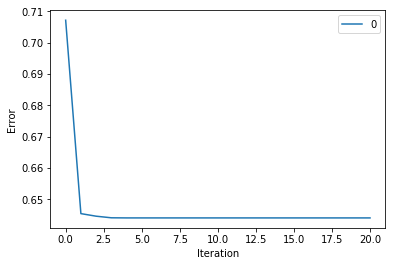

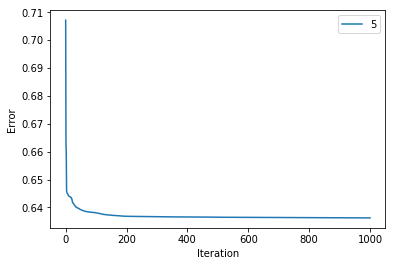

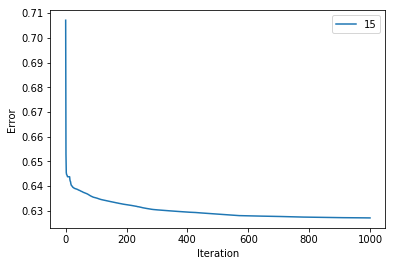

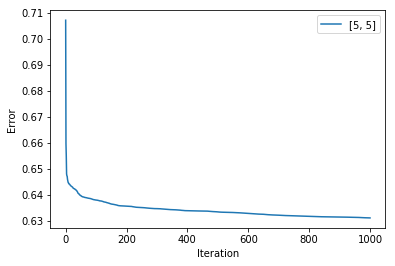

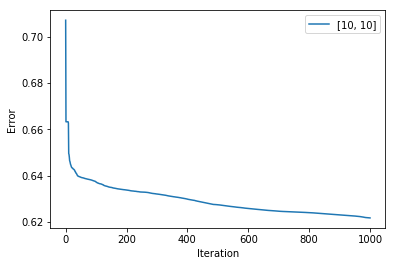

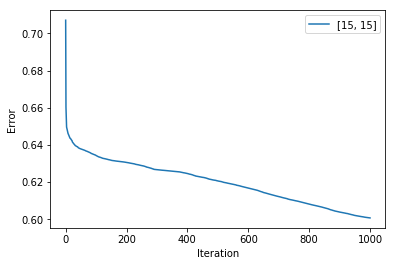

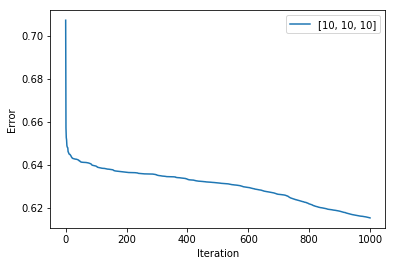

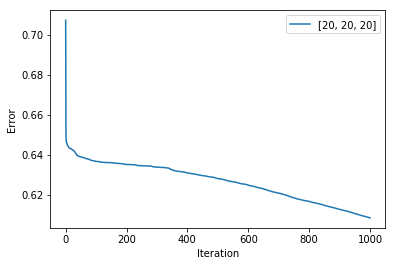

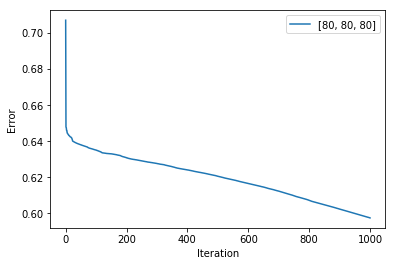

In [15]:
testLayerStructures(Xw5, Tc5, hiddenLayers, 1000)

### Error is still fairly high at 0.63, increase the number of layers and nodes at each layer as well as iterations

In [16]:
hiddenLayers2 = [[20, 20, 20], [20, 20, 20, 20], [40, 40, 40]]

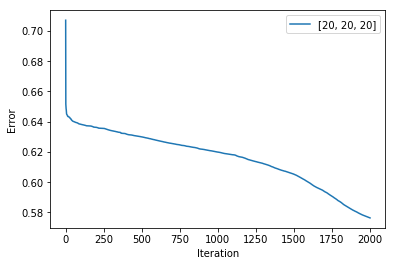

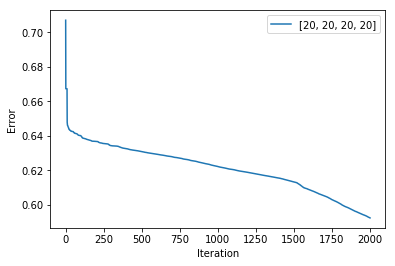

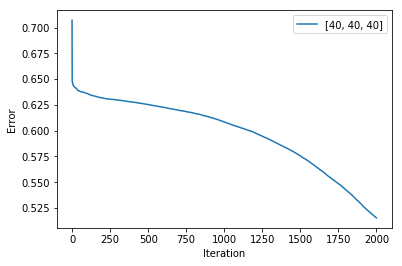

In [17]:
testLayerStructures(Xw5, Tc5, hiddenLayers2, 2000)

### We did a little better, lowering error to 0.45, try again with more nodes and iterations

In [18]:
hiddenLayers3 = [[80, 80, 80], [100, 100, 100], [80, 80, 80, 80]]

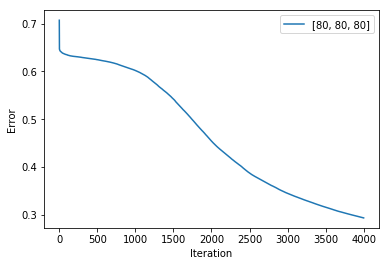

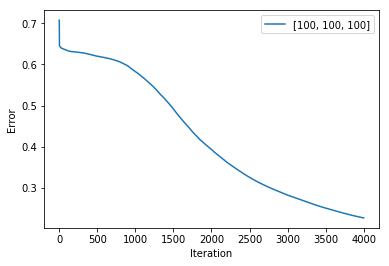

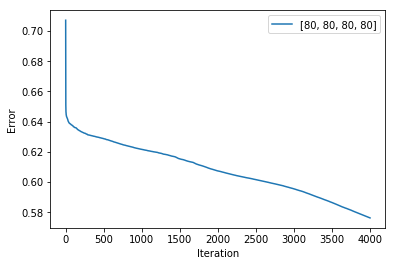

In [19]:
testLayerStructures(Xw5, Tc5, hiddenLayers3, 4000)

#### This code was run on both district 7 and district 5 (shown), error dips lowest on the [80, 80, 80, 80] network

However, I have have to run so many iterations that it over-trains the model

It looks like a linear network or 5 works best on 100-1000 iterations

In [20]:
results = trainNNs(Xw5, Tc5, 0.8, hiddenLayers, 10, 1000)

In [21]:
summarize(results)

[[0, 35.89024594504333, 36.27598236261179, 0.07080936431884766],
 [5, 35.27260150697699, 36.28979796045745, 7.246647357940674],
 [15, 34.426176247575555, 37.430127082756265, 7.56672477722168],
 [[5, 5], 34.51807655504724, 37.8720352313602, 12.267183542251587],
 [[10, 10], 33.4471646292819, 37.60705544479056, 18.29904866218567],
 [[15, 15], 32.20828829305291, 39.1556863227834, 12.155483722686768],
 [[10, 10, 10], 33.38580056261887, 38.28707404080961, 23.579922199249268],
 [[20, 20, 20], 32.4175047299999, 39.75475727341059, 20.460267066955566],
 [[80, 80, 80], 31.26375068513176, 41.11166475297157, 68.7331337928772]]

In [22]:
bestNetwork(summarize(results))

[0, 35.89024594504333, 36.27598236261179, 0.07080936431884766]

In [23]:
results = trainNNs(Xw5, Tc5, 0.8, hiddenLayers2, 10, 1000)

In [24]:
summarize(results)

[[[20, 20, 20], 32.58798211854682, 39.20292620509079, 17.804371118545532],
 [[20, 20, 20, 20], 33.73219350841752, 37.94854336855407, 22.595556259155273],
 [[40, 40, 40], 31.362992343709493, 41.87317548371167, 27.94823718070984]]

In [25]:
bestNetwork(summarize(results))

[[20, 20, 20, 20], 33.73219350841752, 37.94854336855407, 22.595556259155273]

In [26]:
results = trainNNs(Xw5, Tc5, 0.8, hiddenLayers3, 10, 1000)

In [27]:
summarize(results)

[[[80, 80, 80], 29.360661619473213, 44.35857145331492, 877.6751816272736],
 [[100, 100, 100], 30.07667058550562, 42.89139142511662, 87.25957465171814],
 [[80, 80, 80, 80], 33.50442975138175, 38.502819011125915, 87.97765278816223]]

In [28]:
bestNetwork(summarize(results))

[[80, 80, 80, 80], 33.50442975138175, 38.502819011125915, 87.97765278816223]

# District 5

In [164]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw5, Tc5, (0.8, 0.2), classify)


nnet_3000 = nn.NeuralNetwork(Xw5.shape[1], 5, Tc5.shape[1])
nnet_3000.train(Xtrain, Ttrain, 1000)
           
Ytrain_3000 = nnet_3000.use(Xtrain)
Ytest_3000 = nnet_3000.use(Xtest)

In [165]:
print("Homicide Standard Deviations, Actual: ", np.std(Ytest_3000[:,0]), "  Predicted: ", np.std(Ttest[:,0]), " ", np.std(Ytest_3000[:,0] - Ttest[:,0])/np.mean(Tc5[:,0]))
print("Robbery Standard Deviations, Actual: ", np.std(Ytest_3000[:,1]), "  Predicted: ", np.std(Ttest[:,1]), " ", np.std(Ytest_3000[:,1] - Ttest[:,1])/np.mean(Tc5[:,1]))
print("Battery Standard Deviations, Actual: ", np.std(Ytest_3000[:,2]), "  Predicted: ", np.std(Ttest[:,2]), " ", np.std(Ytest_3000[:,2] - Ttest[:,2])/np.mean(Tc5[:,2]))
print("Assault Standard Deviations, Actual: ", np.std(Ytest_3000[:,3]), "  Predicted: ", np.std(Ttest[:,3]), " ", np.std(Ytest_3000[:,3] - Ttest[:,3])/np.mean(Tc5[:,3]))
print("Burglary Standard Deviations, Actual: ", np.std(Ytest_3000[:,4]), "  Predicted: ", np.std(Ttest[:,4]), " ", np.std(Ytest_3000[:,4] - Ttest[:,4])/np.mean(Tc5[:,4]))
print("Theft Standard Deviations, Actual: ", np.std(Ytest_3000[:,5]), "  Predicted: ", np.std(Ttest[:,5]), " ", np.std(Ytest_3000[:,5] - Ttest[:,5])/np.mean(Tc5[:,5]))
print("Motor Vehicle Theft, Actual: ", np.std(Ytest_3000[:,6]), "  Predicted: ", np.std(Ttest[:,6]),  " ", np.std(Ytest_3000[:,6] - Ttest[:,6])/np.mean(Tc5[:,6]))
print("Weapons Violation, Actual: ", np.std(Ytest_3000[:,7]), "  Predicted: ", np.std(Ttest[:,7]), " ", np.std(Ytest_3000[:,7] - Ttest[:,7])/np.mean(Tc5[:,7]))



Homicide Standard Deviations, Actual:  0.5039859337422664   Predicted:  1.9335919211884485   0.6373562672236367
Robbery Standard Deviations, Actual:  5.707127676336257   Predicted:  19.841341856685947   0.264015612260714
Battery Standard Deviations, Actual:  47.416201904576575   Predicted:  93.87088870688183   0.23092621936670596
Assault Standard Deviations, Actual:  14.568155942182097   Predicted:  27.931162000684665   0.21193493851135387
Burglary Standard Deviations, Actual:  8.93188327395762   Predicted:  23.49616207455251   0.29032638677663386
Theft Standard Deviations, Actual:  32.59947278895291   Predicted:  77.1573743140148   0.21045384429668548
Motor Vehicle Theft, Actual:  3.960081646595422   Predicted:  20.976475885202124   0.28443314506688433
Weapons Violation, Actual:  2.0626663093716893   Predicted:  7.865389523260945   0.3838634758177464


In [166]:
def printCorrelationStats(Ytest, Ttest, Tc, district):
    
    print("District ", district, ": Pearsons Coefficients Actual vs Predicted Data\n")
    
    print("Homicide \nR = ",np.corrcoef(Ttest[:,0], Ytest[:,0])[1:,0], " RMSE = ",np.sqrt(np.mean((Ytest[:,0]-Ttest[:,0])**2)), "\n")
    print("Robbery \nR = ",np.corrcoef(Ttest[:,1], Ytest[:,1])[1:,0], " RMSE = ",np.sqrt(np.mean((Ytest[:,1]-Ttest[:,1])**2)), "\n")
    print("Battery \nR = ",np.corrcoef(Ttest[:,2], Ytest[:,2])[1:,0], " RMSE = ",np.sqrt(np.mean((Ytest[:,2]-Ttest[:,2])**2)), "\n")
    print("Assault \nR = ",np.corrcoef(Ttest[:,3], Ytest[:,3])[1:,0], " RMSE = ",np.sqrt(np.mean((Ytest[:,3]-Ttest[:,3])**2)), "\n")
    print("Burglary \nR = ",np.corrcoef(Ttest[:,4], Ytest[:,4])[1:,0], " RMSE = ",np.sqrt(np.mean((Ytest[:,4]-Ttest[:,4])**2)), "\n")
    print("Theft \nR = ",np.corrcoef(Ttest[:,5], Ytest[:,5])[1:,0], " RMSE = ",np.sqrt(np.mean((Ytest[:,5]-Ttest[:,5])**2)), "\n")
    print("Motor Vehicle Theft \nR = ",np.corrcoef(Ttest[:,6], Ytest[:,6])[1:,0], " RMSE = ",np.sqrt(np.mean((Ytest[:,6]-Ttest[:,6])**2)), "\n")
    print("Weapons Violation \nR = ",np.corrcoef(Ttest[:,7], Ytest[:,7])[1:,0], " RMSE = ",np.sqrt(np.mean((Ytest[:,7]-Ttest[:,7])**2)), "\n")
    

In [167]:
printCorrelationStats(Ytest_3000, Ttest, Tc5, "5")

District  5 : Pearsons Coefficients Actual vs Predicted Data

Homicide 
R =  [0.20892725]  RMSE =  1.9460113116540432 

Robbery 
R =  [0.4214554]  RMSE =  18.19247466730188 

Battery 
R =  [0.65111067]  RMSE =  72.81747552290925 

Assault 
R =  [0.68820979]  RMSE =  20.826238771846295 

Burglary 
R =  [0.39187157]  RMSE =  21.66243281829095 

Theft 
R =  [0.55251147]  RMSE =  65.17259574839206 

Motor Vehicle Theft 
R =  [0.31877882]  RMSE =  20.07062676022254 

Weapons Violation 
R =  [0.27026739]  RMSE =  7.577501335954286 



DISTRICT 5
Hidden Layer Structure: 0, Number Iterations: 1000


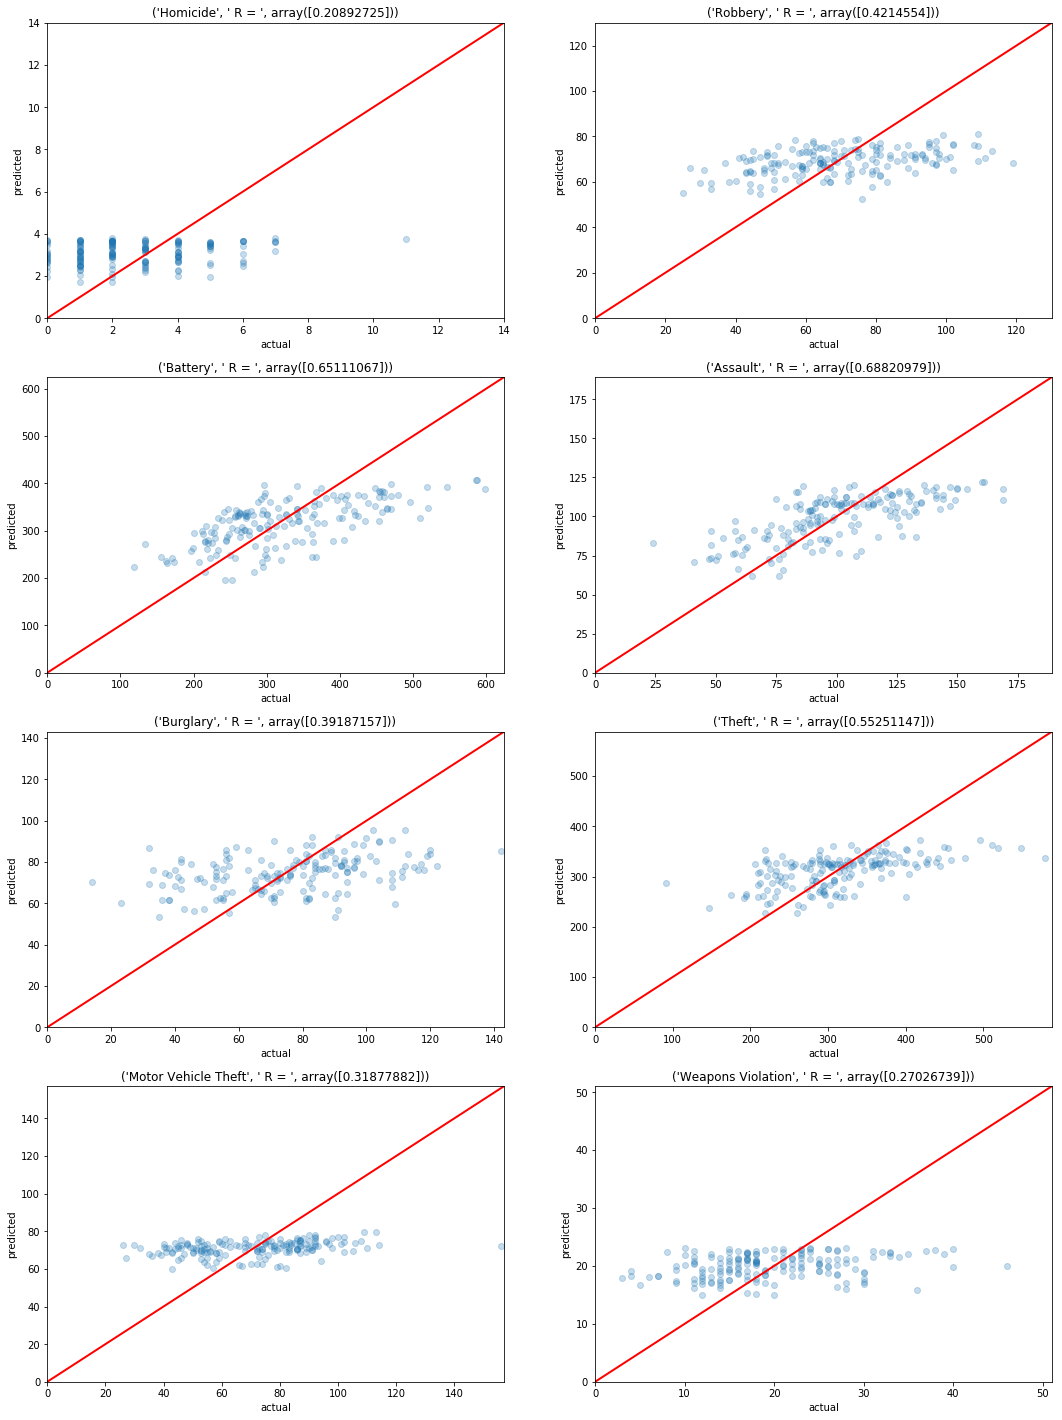

In [168]:
scatterPlotCrimes("5", "0", '1000', Tc5, Ttest, Ytest_3000)

DISTRICT 5
Hidden Layer Structure: 0 Number Iterations: 1000


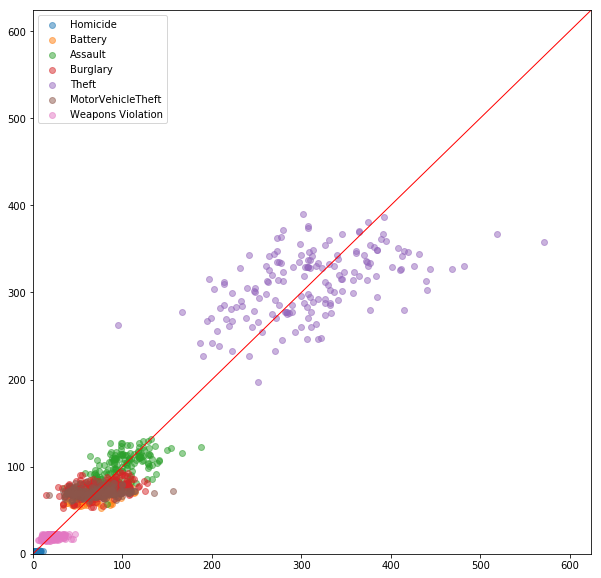

In [34]:
plotAllResults("5", "0", '1000', Tc5, Ttest, Ytest_3000)

## District 1

In [35]:
Xw1, Tc1 = loadWeatherData("wc1.csv", 3)

In [36]:
results = trainNNs(Xw1, Tc1, 0.8, hiddenLayers, 10, 1000)

In [37]:
summarize(results)

[[0, 21.763377933578518, 22.00343640886366, 0.06781959533691406],
 [5, 21.298417584058424, 21.6438234514873, 7.620612382888794],
 [15, 20.729384960462117, 22.275273850479245, 8.20305848121643],
 [[5, 5], 20.69767745606496, 22.80163751542137, 12.34098505973816],
 [[10, 10], 19.594073801269975, 23.96833199212876, 20.24284863471985],
 [[15, 15], 18.766531454367858, 25.336619773357143, 12.6780846118927],
 [[10, 10, 10], 19.344788034685564, 24.726689734791243, 25.016080379486084],
 [[20, 20, 20], 17.95329522448847, 26.442106008195918, 19.920711040496826],
 [[80, 80, 80], 16.53327691486225, 28.45762961878874, 60.710596323013306]]

In [38]:
bestNetwork(summarize(results))

[5, 21.298417584058424, 21.6438234514873, 7.620612382888794]

In [127]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw1, Tc1, (0.8, 0.2), classify)


#training with 3000 iterations
nnet_1 = nn.NeuralNetwork(Xw1.shape[1], 5, Tc1.shape[1])
nnet_1.train(Xtrain, Ttrain, 1000)
           
Ytrain_1 = nnet_1.use(Xtrain)
Ytest_1 = nnet_1.use(Xtest)

In [128]:
printCorrelationStats(Ytest_1, Ttest, Tc1, "1")

District  1 : Pearsons Coefficients Actual vs Predicted Data

Homicide 
R =  [0.09480572]  RMSE =  0.6792313610574389 

Robbery 
R =  [0.29549477]  RMSE =  7.322584518228366 

Battery 
R =  [0.1710864]  RMSE =  36.70113742046932 

Assault 
R =  [0.16156867]  RMSE =  14.886349639905054 

Burglary 
R =  [0.32193984]  RMSE =  12.809659879351212 

Theft 
R =  [0.40169427]  RMSE =  39.553257560930305 

Motor Vehicle Theft 
R =  [0.24482385]  RMSE =  20.06625604864059 

Weapons Violation 
R =  [0.16506674]  RMSE =  3.2491646818299396 



DISTRICT 1
Hidden Layer Structure: 5, Number Iterations: 1000


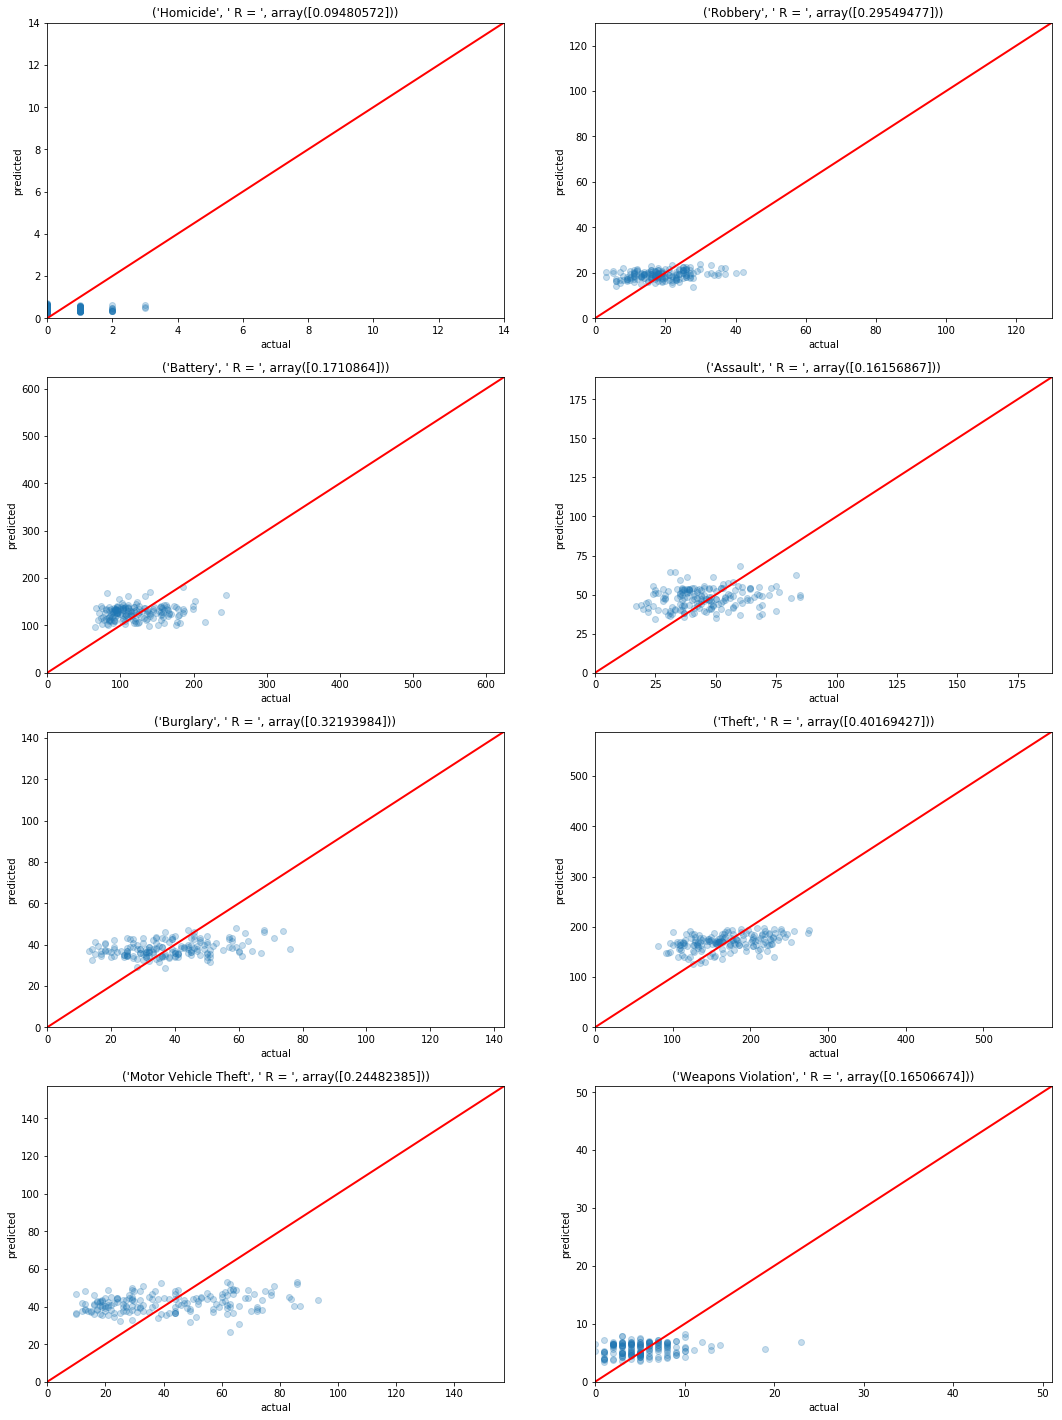

In [129]:
scatterPlotCrimes("1", "5", '1000', Tc1, Ttest, Ytest_1)

# District 2

In [42]:
Xw2, Tc2 = loadWeatherData("wc2.csv", 3)

In [43]:
results = trainNNs(Xw2, Tc2, 0.8, hiddenLayers, 10, 1000)

In [44]:
summarize(results)

[[0, 18.848002925590244, 18.694196597709713, 0.05684947967529297],
 [5, 18.409022311881564, 19.341249945178355, 7.71136999130249],
 [15, 18.020108391444452, 19.344143908526654, 8.218015909194946],
 [[5, 5], 18.186459654671182, 19.46403929059937, 11.998902797698975],
 [[10, 10], 17.29887073750141, 20.732197843420693, 20.3395893573761],
 [[15, 15], 16.66117435785074, 21.466399595957846, 14.027475357055664],
 [[10, 10, 10], 17.135554215599907, 20.957632336132384, 28.45288872718811],
 [[20, 20, 20], 16.198852732194222, 22.5871462983686, 19.862863302230835],
 [[80, 80, 80], 14.973724106620566, 23.557695979113326, 68.05793905258179]]

In [45]:
bestNetwork(summarize(results))

[0, 18.848002925590244, 18.694196597709713, 0.05684947967529297]

In [100]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw2, Tc2, (0.8, 0.2), classify)

nnet_2 = nn.NeuralNetwork(Xw2.shape[1], 5 , Tc2.shape[1])
nnet_2.train(Xtrain, Ttrain, 1000)
           
Ytrain_2 = nnet_2.use(Xtrain)
Ytest_2 = nnet_2.use(Xtest)

In [101]:
printCorrelationStats(Ytest_2, Ttest, Tc2, "2")

District  2 : Pearsons Coefficients Actual vs Predicted Data

Homicide 
R =  [0.02445416]  RMSE =  0.6152529445540702 

Robbery 
R =  [0.29257978]  RMSE =  7.622395581495865 

Battery 
R =  [0.25351834]  RMSE =  27.533098804626455 

Assault 
R =  [0.16272573]  RMSE =  11.926849993920701 

Burglary 
R =  [0.2535039]  RMSE =  16.910863427374313 

Theft 
R =  [0.44154178]  RMSE =  45.61749101397491 

Motor Vehicle Theft 
R =  [0.04819974]  RMSE =  15.262152302220473 

Weapons Violation 
R =  [0.13572048]  RMSE =  2.7086471449345813 



DISTRICT 2
Hidden Layer Structure: 5, Number Iterations: 1000


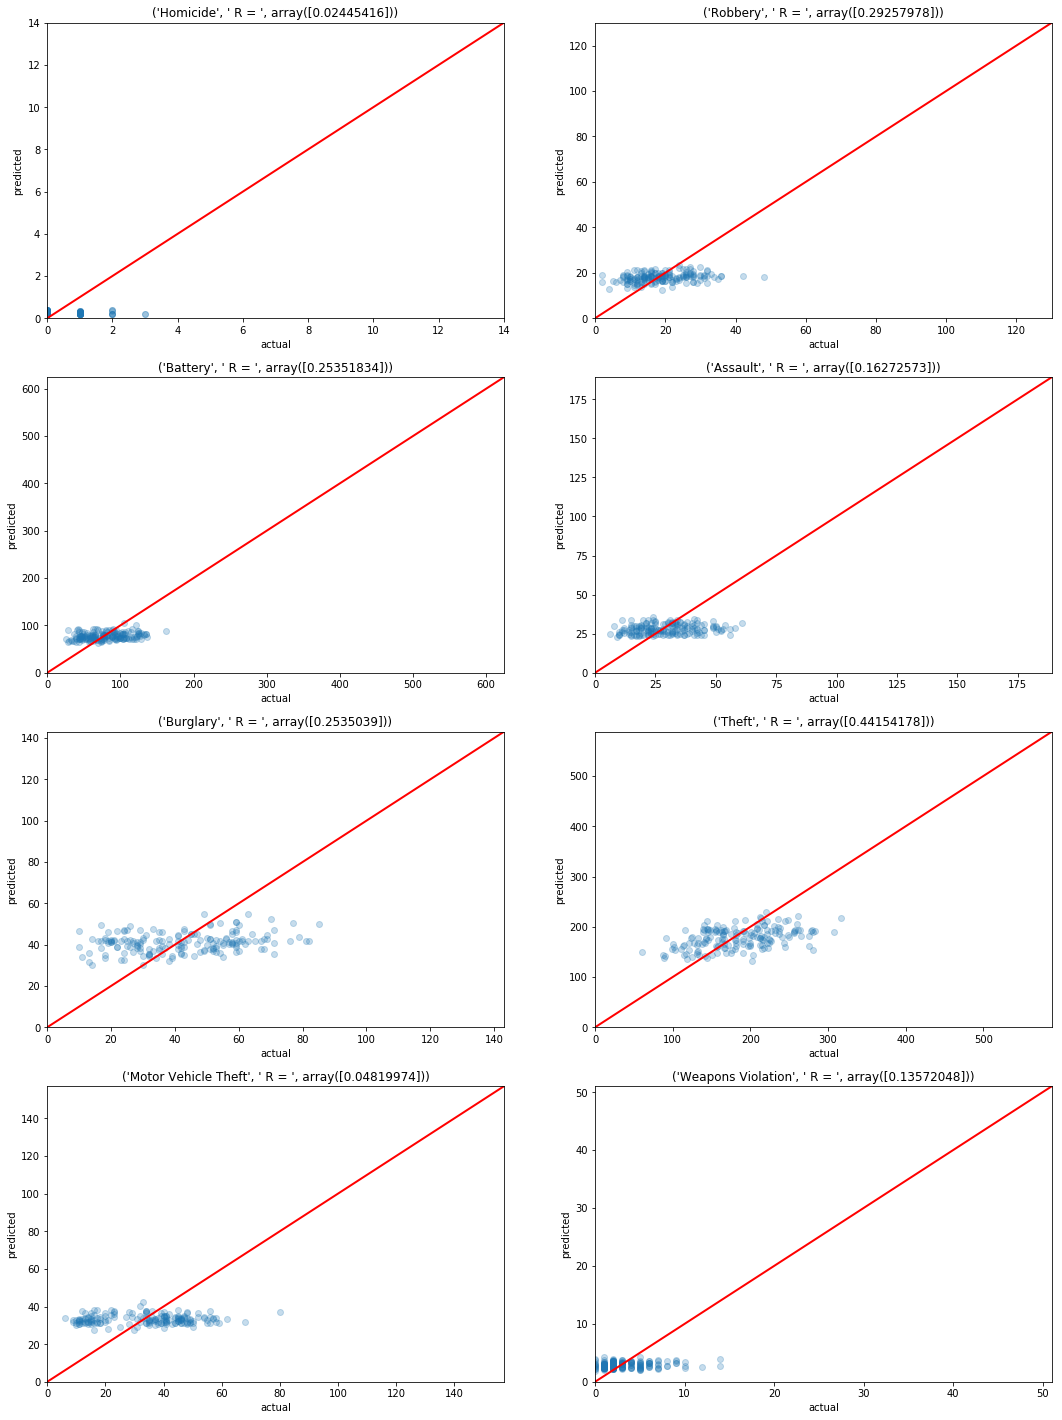

In [103]:
scatterPlotCrimes("2", "5", '1000', Tc2, Ttest, Ytest_2)

# District 3

In [49]:
Xw3, Tc3 = loadWeatherData("wc3.csv", 3)

In [50]:
results = trainNNs(Xw3, Tc3, 0.8, hiddenLayers, 10, 1000)

In [51]:
summarize(results)

[[0, 12.770576788782906, 13.068010926887444, 0.050861358642578125],
 [5, 12.536493688632046, 12.945353723728157, 7.255589485168457],
 [15, 12.213800505032413, 13.34911332716419, 7.631585121154785],
 [[5, 5], 12.379471631513962, 13.073092001368241, 11.255889654159546],
 [[10, 10], 11.772055425693958, 14.111861771012315, 18.038745641708374],
 [[15, 15], 11.477970484763985, 14.26946974770722, 12.256213426589966],
 [[10, 10, 10], 11.568727657489664, 14.04932491545215, 24.814618825912476],
 [[20, 20, 20], 10.936739821579215, 14.918045943423746, 17.7874174118042],
 [[80, 80, 80], 9.626006448805523, 16.667920313104172, 62.080928802490234]]

In [52]:
bestNetwork(summarize(results))

[5, 12.536493688632046, 12.945353723728157, 7.255589485168457]

In [130]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw3, Tc3, (0.8, 0.2), classify)


#training with 3000 iterations
nnet_3 = nn.NeuralNetwork(Xw3.shape[1], 5, Tc3.shape[1])
nnet_3.train(Xtrain, Ttrain, 1000)
           
Ytrain_3 = nnet_3.use(Xtrain)
Ytest_3 = nnet_3.use(Xtest)

In [131]:
printCorrelationStats(Ytest_3, Ttest, Tc3, "3")

District  3 : Pearsons Coefficients Actual vs Predicted Data

Homicide 
R =  [0.05235028]  RMSE =  0.44942212145449933 

Robbery 
R =  [0.05821507]  RMSE =  5.092493426436306 

Battery 
R =  [0.32542837]  RMSE =  18.927357992811018 

Assault 
R =  [0.39195824]  RMSE =  8.114913333248387 

Burglary 
R =  [0.0717044]  RMSE =  12.334374143456227 

Theft 
R =  [0.20503882]  RMSE =  26.78188542359611 

Motor Vehicle Theft 
R =  [0.14930687]  RMSE =  11.290880007941295 

Weapons Violation 
R =  [0.09956794]  RMSE =  2.589525323008547 



DISTRICT 3
Hidden Layer Structure: 5, Number Iterations: 1000


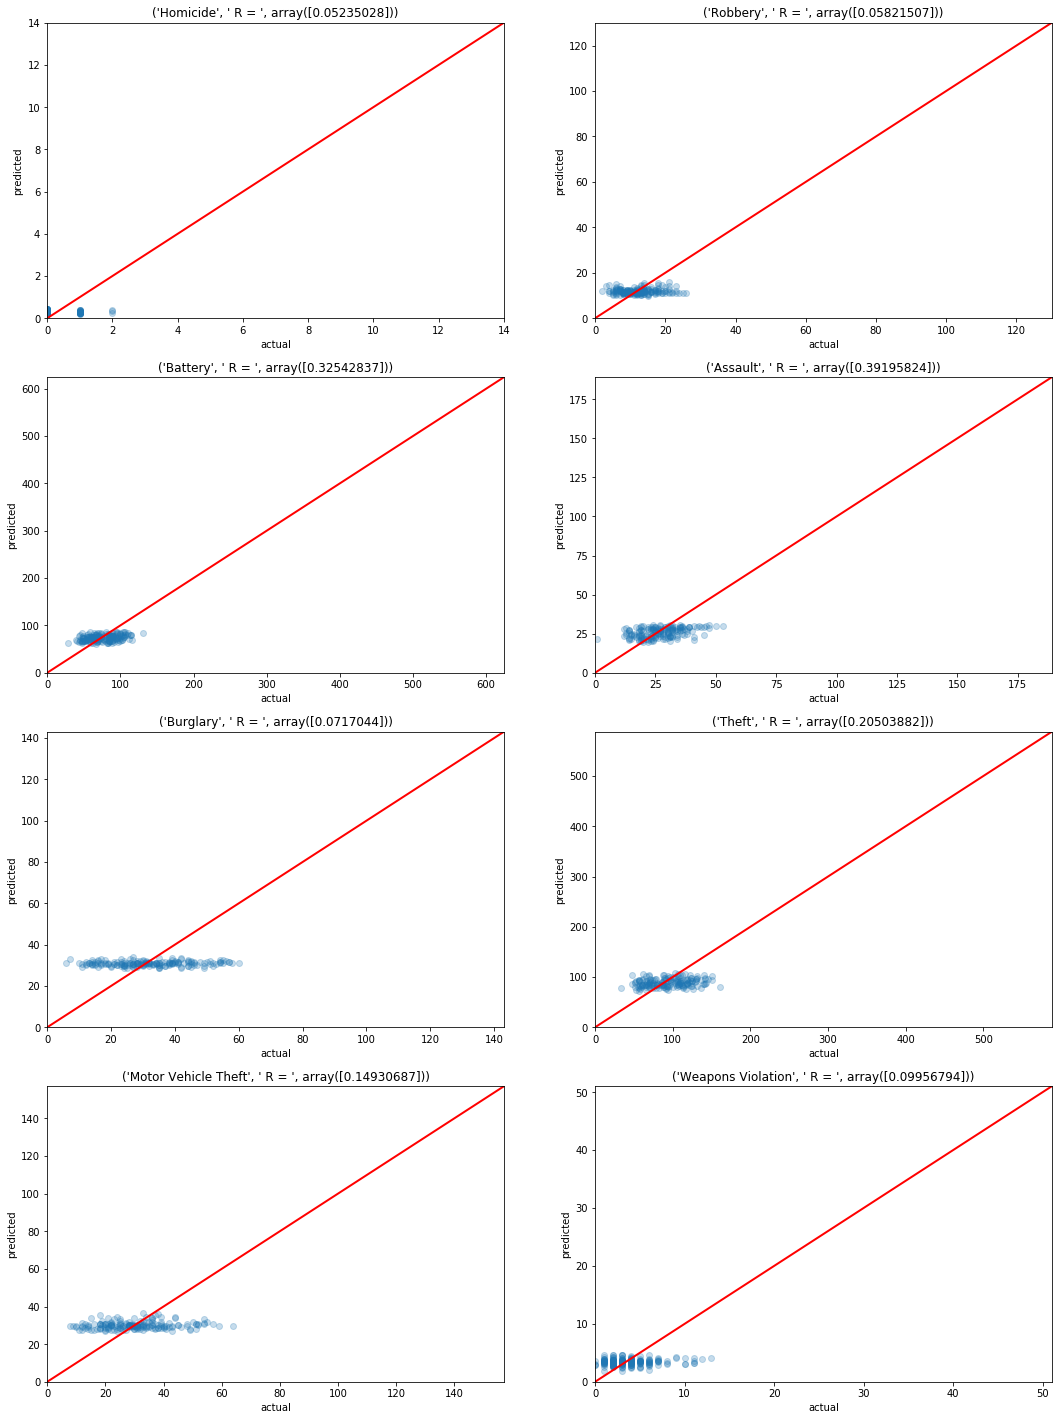

In [132]:
scatterPlotCrimes("3", "5", '1000', Tc3, Ttest, Ytest_3)

# District 4

In [56]:
Xw4, Tc4 = loadWeatherData("wc4.csv", 3)

In [57]:
results = trainNNs(Xw4, Tc4, 0.8, hiddenLayers, 10, 1000)

In [58]:
summarize(results)

[[0, 13.75987698132029, 14.362577531168663, 0.0638267993927002],
 [5, 13.717796681197077, 14.051666547339163, 7.5298919677734375],
 [15, 13.614750292528774, 13.649872862661947, 7.682413578033447],
 [[5, 5], 13.654253195061859, 14.26228853971362, 11.525168657302856],
 [[10, 10], 13.157475389332621, 14.961866119987187, 18.67105460166931],
 [[15, 15], 12.633949855635738, 16.205979247499144, 12.006880044937134],
 [[10, 10, 10], 12.832719137008695, 15.957985821951075, 25.25544047355652],
 [[20, 20, 20], 12.448544368536032, 15.986615362982963, 17.96992826461792],
 [[80, 80, 80], 10.603253705734494, 18.3577072507798, 62.17866778373718]]

In [59]:
bestNetwork(summarize(results))

[15, 13.614750292528774, 13.649872862661947, 7.682413578033447]

In [133]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw4, Tc4, (0.8, 0.2), classify)


#training with 3000 iterations
nnet_4 = nn.NeuralNetwork(Xw4.shape[1], 5, Tc4.shape[1])
nnet_4.train(Xtrain, Ttrain, 1000)
           
Ytrain_4 = nnet_4.use(Xtrain)
Ytest_4 = nnet_4.use(Xtest)

In [134]:
printCorrelationStats(Ytest_4, Ttest, Tc4, "4")

District  4 : Pearsons Coefficients Actual vs Predicted Data

Homicide 
R =  [0.05337512]  RMSE =  0.40460730756302915 

Robbery 
R =  [0.28216148]  RMSE =  4.880409808575755 

Battery 
R =  [0.32999735]  RMSE =  15.452819414931884 

Assault 
R =  [0.20223106]  RMSE =  6.519240749759253 

Burglary 
R =  [0.20335893]  RMSE =  4.8082705942194 

Theft 
R =  [0.58131131]  RMSE =  29.281623621097825 

Motor Vehicle Theft 
R =  [0.09505341]  RMSE =  5.225015517693333 

Weapons Violation 
R =  [0.14042601]  RMSE =  1.4001389678017766 



DISTRICT 4
Hidden Layer Structure: 5, Number Iterations: 1000


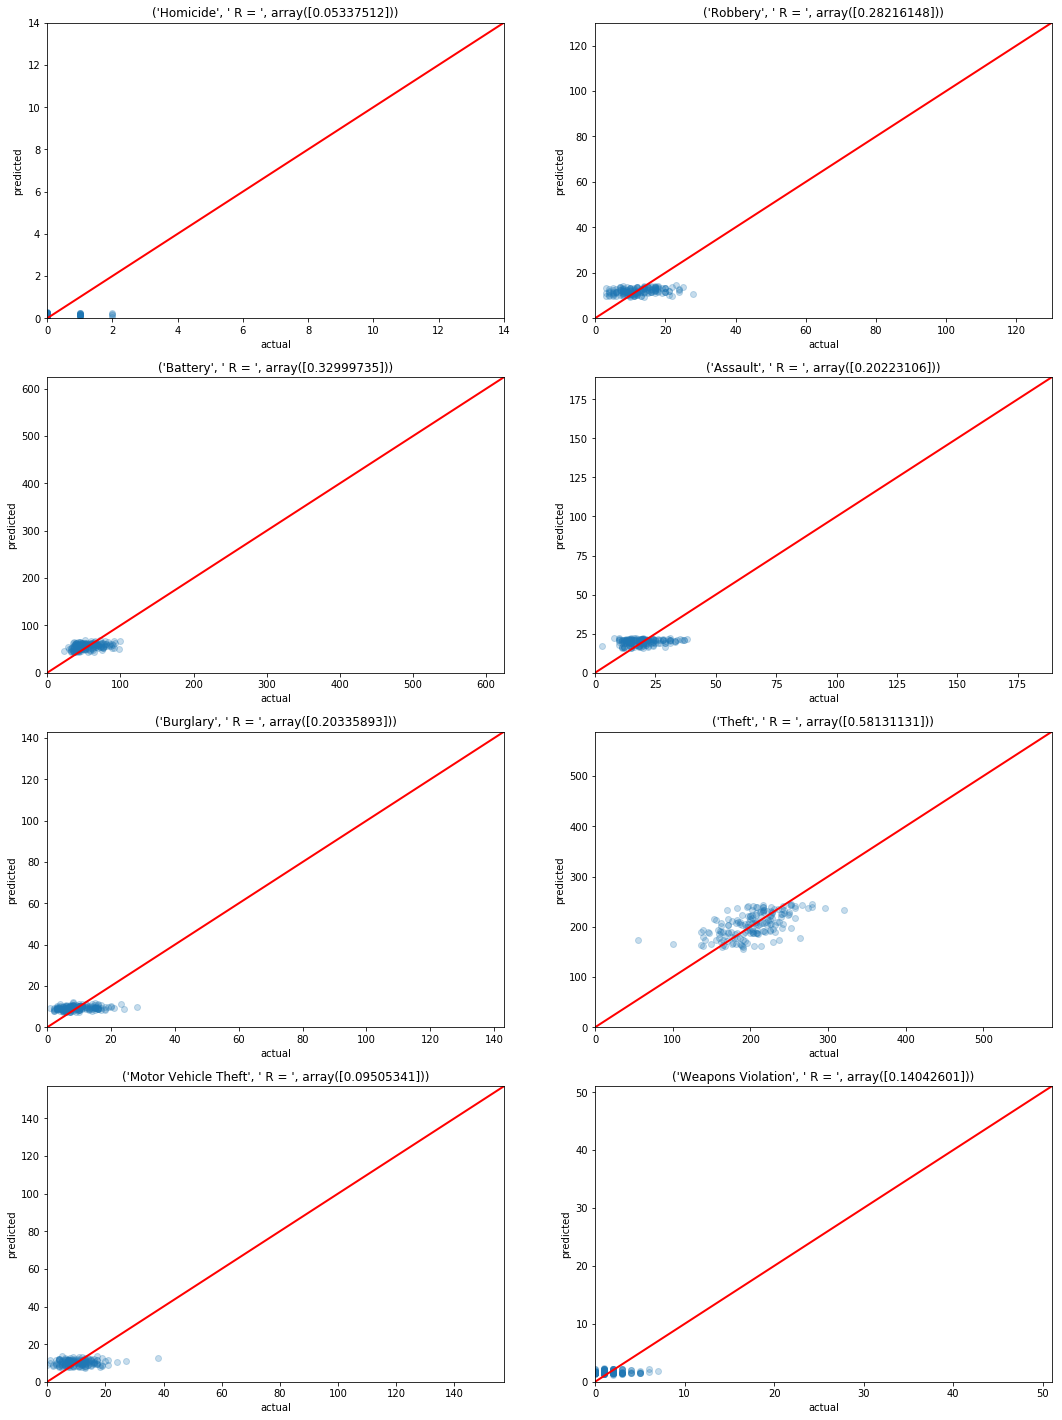

In [135]:
scatterPlotCrimes("4", "5", '1000', Tc4, Ttest, Ytest_4)

# District 6

In [63]:
Xw6, Tc6 = loadWeatherData("wc6.csv", 3)

In [64]:
results = trainNNs(Xw6, Tc6, 0.8, hiddenLayers, 10, 1000)

In [65]:
summarize(results)

[[0, 29.59149028245266, 29.739233642525495, 0.07480025291442871],
 [5, 28.843398103275263, 30.460763189000943, 7.282517671585083],
 [15, 28.048536155216148, 30.638689983236354, 7.526869058609009],
 [[5, 5], 28.384833117923318, 30.616268326955357, 11.007552862167358],
 [[10, 10], 27.070100782042186, 31.908077246662806, 17.509159803390503],
 [[15, 15], 26.040077886218633, 33.44739682226119, 11.934074640274048],
 [[10, 10, 10], 27.01812399700969, 31.900284908207396, 23.120153665542603],
 [[20, 20, 20], 26.262241113175993, 33.10186722965564, 17.93901038169861],
 [[80, 80, 80], 25.058332140373313, 34.591957318665486, 64.41867542266846]]

In [66]:
bestNetwork(summarize(results))

[0, 29.59149028245266, 29.739233642525495, 0.07480025291442871]

In [136]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw6, Tc6, (0.8, 0.2), classify)


#training with 3000 iterations
nnet_6 = nn.NeuralNetwork(Xw6.shape[1], 5, Tc6.shape[1])
nnet_6.train(Xtrain, Ttrain, 1000)
           
Ytrain_6 = nnet_6.use(Xtrain)
Ytest_6 = nnet_6.use(Xtest)

In [137]:
printCorrelationStats(Ytest_6, Ttest, Tc6, "6")

District  6 : Pearsons Coefficients Actual vs Predicted Data

Homicide 
R =  [0.27304866]  RMSE =  1.513467022760058 

Robbery 
R =  [0.30285095]  RMSE =  12.466217756965566 

Battery 
R =  [0.51529153]  RMSE =  59.897095524774464 

Assault 
R =  [0.54189317]  RMSE =  18.92491379173938 

Burglary 
R =  [0.12290851]  RMSE =  25.575579789694206 

Theft 
R =  [0.2745758]  RMSE =  47.205993991183156 

Motor Vehicle Theft 
R =  [0.07386549]  RMSE =  19.820487154489538 

Weapons Violation 
R =  [0.33497989]  RMSE =  5.963976796816021 



DISTRICT 6
Hidden Layer Structure: 5, Number Iterations: 1000


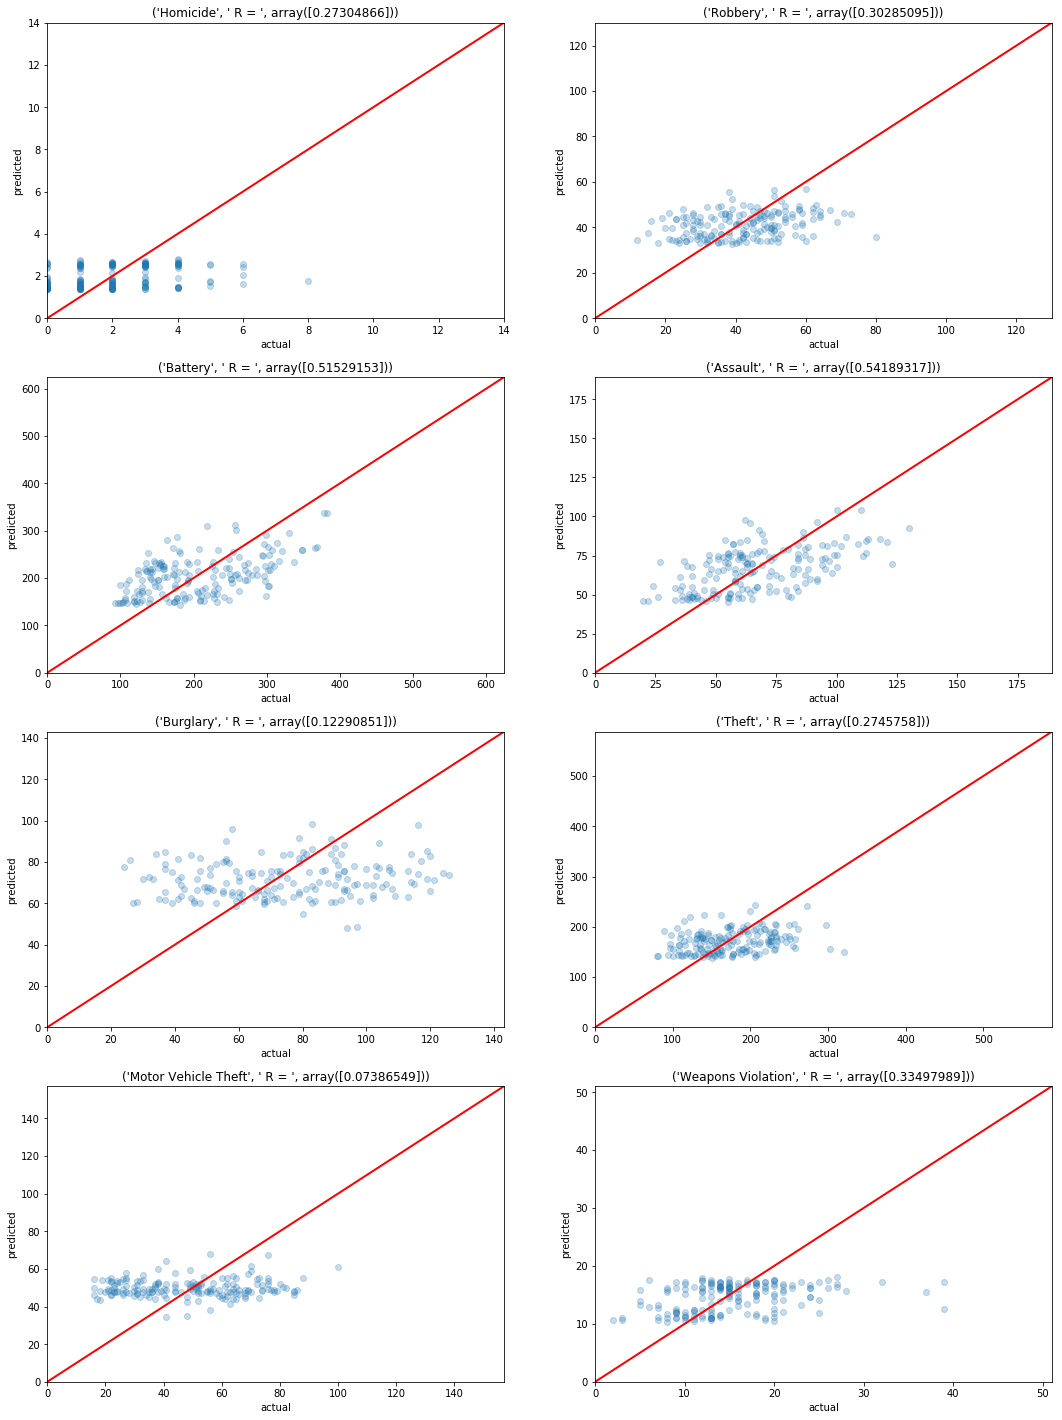

In [138]:
scatterPlotCrimes("6", "5", '1000', Tc6, Ttest, Ytest_6)

# District 7

In [70]:
Xw7, Tc7 = loadWeatherData("wc7.csv", 3)

In [71]:
results = trainNNs(Xw7, Tc7, 0.8, hiddenLayers, 10, 1000)

In [72]:
summarize(results)

[[0, 5.460592818424894, 5.444532471583257, 0.12765789031982422],
 [5, 5.451614923903612, 5.432181131396373, 16.144811391830444],
 [15, 5.422056973581604, 5.46600006287643, 26.240804433822632],
 [[5, 5], 5.429649441512469, 5.482125137680732, 23.67167639732361],
 [[10, 10], 5.420105065473128, 5.445961644029577, 35.97277069091797],
 [[15, 15], 5.40640516247169, 5.454149708128806, 60.50015735626221],
 [[10, 10, 10], 5.401016809168583, 5.51482868967715, 47.5627646446228],
 [[20, 20, 20], 5.39401985093992, 5.5149001361594285, 120.2024495601654],
 [[80, 80, 80], 5.383829916519874, 5.520193592036774, 909.6511960029602]]

In [73]:
bestNetwork(summarize(results))

[5, 5.451614923903612, 5.432181131396373, 16.144811391830444]

In [143]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw7, Tc7, (0.8, 0.2), classify)

nnet_7 = nn.NeuralNetwork(Xw7.shape[1], 5, Tc7.shape[1])
nnet_7.train(Xtrain, Ttrain, 100)
           
Ytrain_7 = nnet_7.use(Xtrain)
Ytest_7 = nnet_7.use(Xtest)

In [144]:
printCorrelationStats(Ytest_7, Ttest, Tc7, "7")

District  7 : Pearsons Coefficients Actual vs Predicted Data

Homicide 
R =  [0.10580638]  RMSE =  0.5139270172883601 

Robbery 
R =  [0.20938111]  RMSE =  3.152680501169221 

Battery 
R =  [0.40496245]  RMSE =  10.68202102561169 

Assault 
R =  [0.35057901]  RMSE =  3.9405316617640587 

Burglary 
R =  [0.20969129]  RMSE =  4.351010713149641 

Theft 
R =  [0.32577681]  RMSE =  8.241648500221823 

Motor Vehicle Theft 
R =  [0.12862446]  RMSE =  3.2198651965313543 

Weapons Violation 
R =  [0.19998276]  RMSE =  1.2467160947201403 



DISTRICT 7
Hidden Layer Structure: 5, Number Iterations: 1000


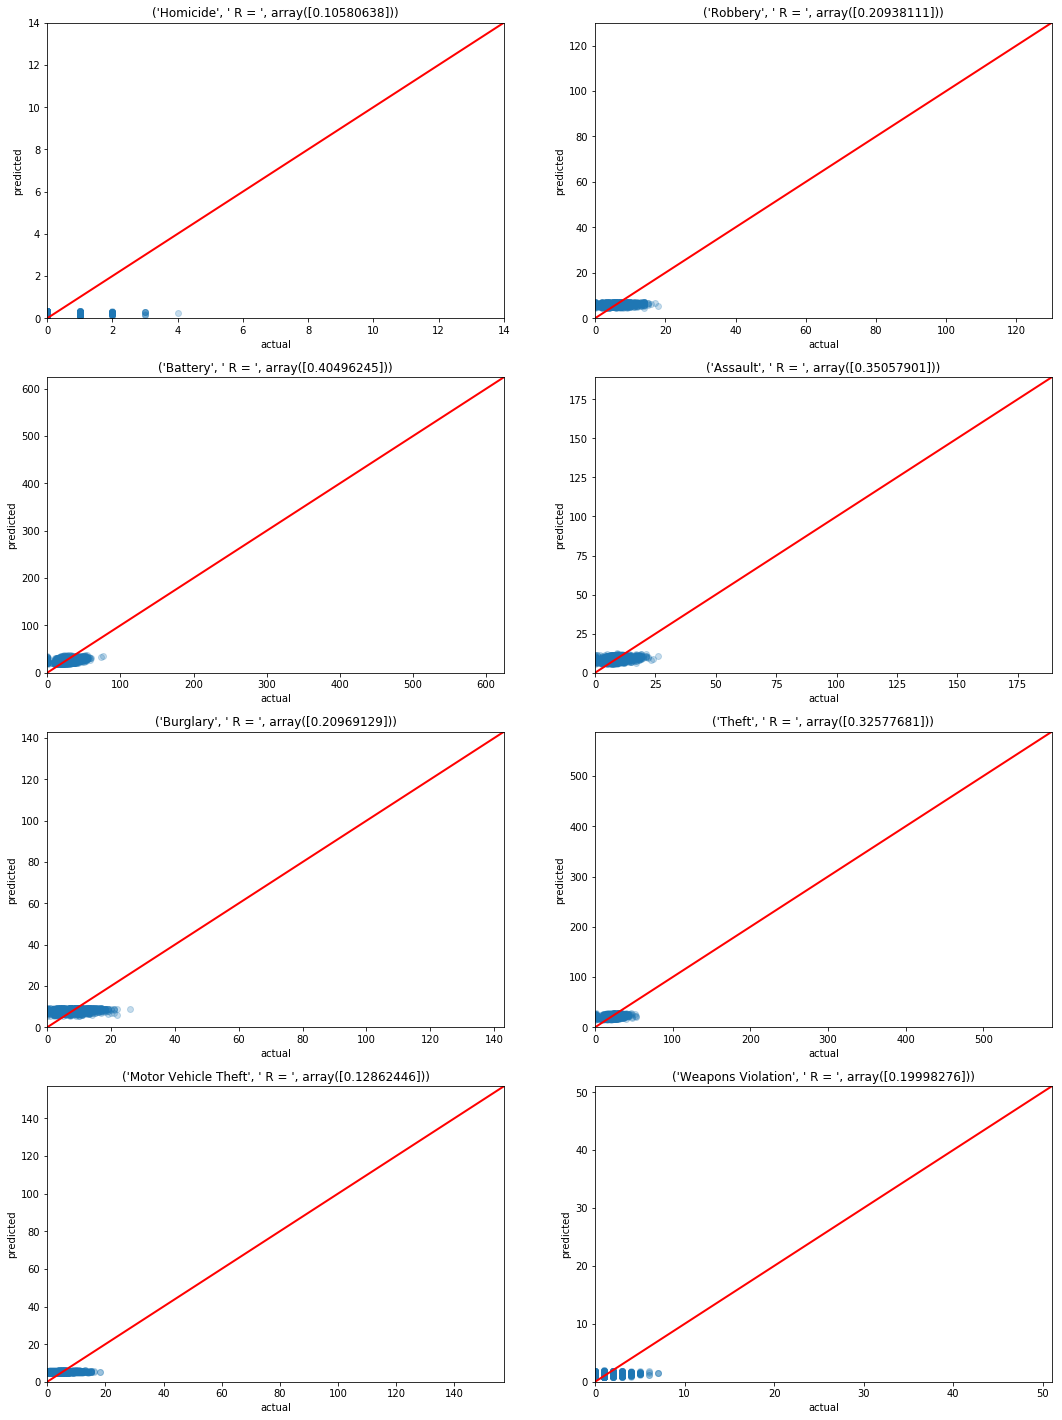

In [146]:
scatterPlotCrimes("7", "5", '1000', Tc7, Ttest, Ytest_7)

# District 8

In [77]:
Xw8, Tc8 = loadWeatherData("wc8.csv", 3)

In [78]:
results = trainNNs(Xw8, Tc8, 0.8, hiddenLayers, 10, 1000)

In [81]:
summarize(results)

[[0, 11.451957399888121, 11.597308713366672, 0.07479286193847656],
 [5, 11.316349448031097, 11.646482479264602, 7.271546840667725],
 [15, 11.097225794580574, 11.843825637345876, 7.653527736663818],
 [[5, 5], 11.227600491685008, 11.574442105745966, 11.272842168807983],
 [[10, 10], 10.809997361247037, 12.364435100053333, 18.298051595687866],
 [[15, 15], 10.566451424595666, 12.604026752163021, 12.231282234191895],
 [[10, 10, 10], 10.754172922629749, 12.239073506883923, 24.294009923934937],
 [[20, 20, 20], 10.29136466979752, 12.851661529428256, 17.907097578048706],
 [[80, 80, 80], 9.017576521884083, 14.812730020237774, 61.24017953872681]]

In [82]:
bestNetwork(summarize(results))

[[5, 5], 11.227600491685008, 11.574442105745966, 11.272842168807983]

In [175]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw8, Tc8, (0.8, 0.2), classify)

nnet_8 = nn.NeuralNetwork(Xw8.shape[1], 5, Tc8.shape[1])
nnet_8.train(Xtrain, Ttrain, 100)
           
Ytrain_8 = nnet_8.use(Xtrain)
Ytest_8 = nnet_8.use(Xtest)

In [176]:
printCorrelationStats(Ytest_8, Ttest, Tc8, "8")

District  8 : Pearsons Coefficients Actual vs Predicted Data

Homicide 
R =  [0.24857821]  RMSE =  0.8516293422924062 

Robbery 
R =  [0.13564681]  RMSE =  6.372923460610683 

Battery 
R =  [0.54741086]  RMSE =  18.85963692582073 

Assault 
R =  [0.57023522]  RMSE =  7.629707886700286 

Burglary 
R =  [0.2988617]  RMSE =  12.880563618925027 

Theft 
R =  [0.47852664]  RMSE =  19.237991735344355 

Motor Vehicle Theft 
R =  [0.04338525]  RMSE =  6.84041273158561 

Weapons Violation 
R =  [0.35798735]  RMSE =  2.3936233139739067 



DISTRICT 8
Hidden Layer Structure: 5, Number Iterations: 1000


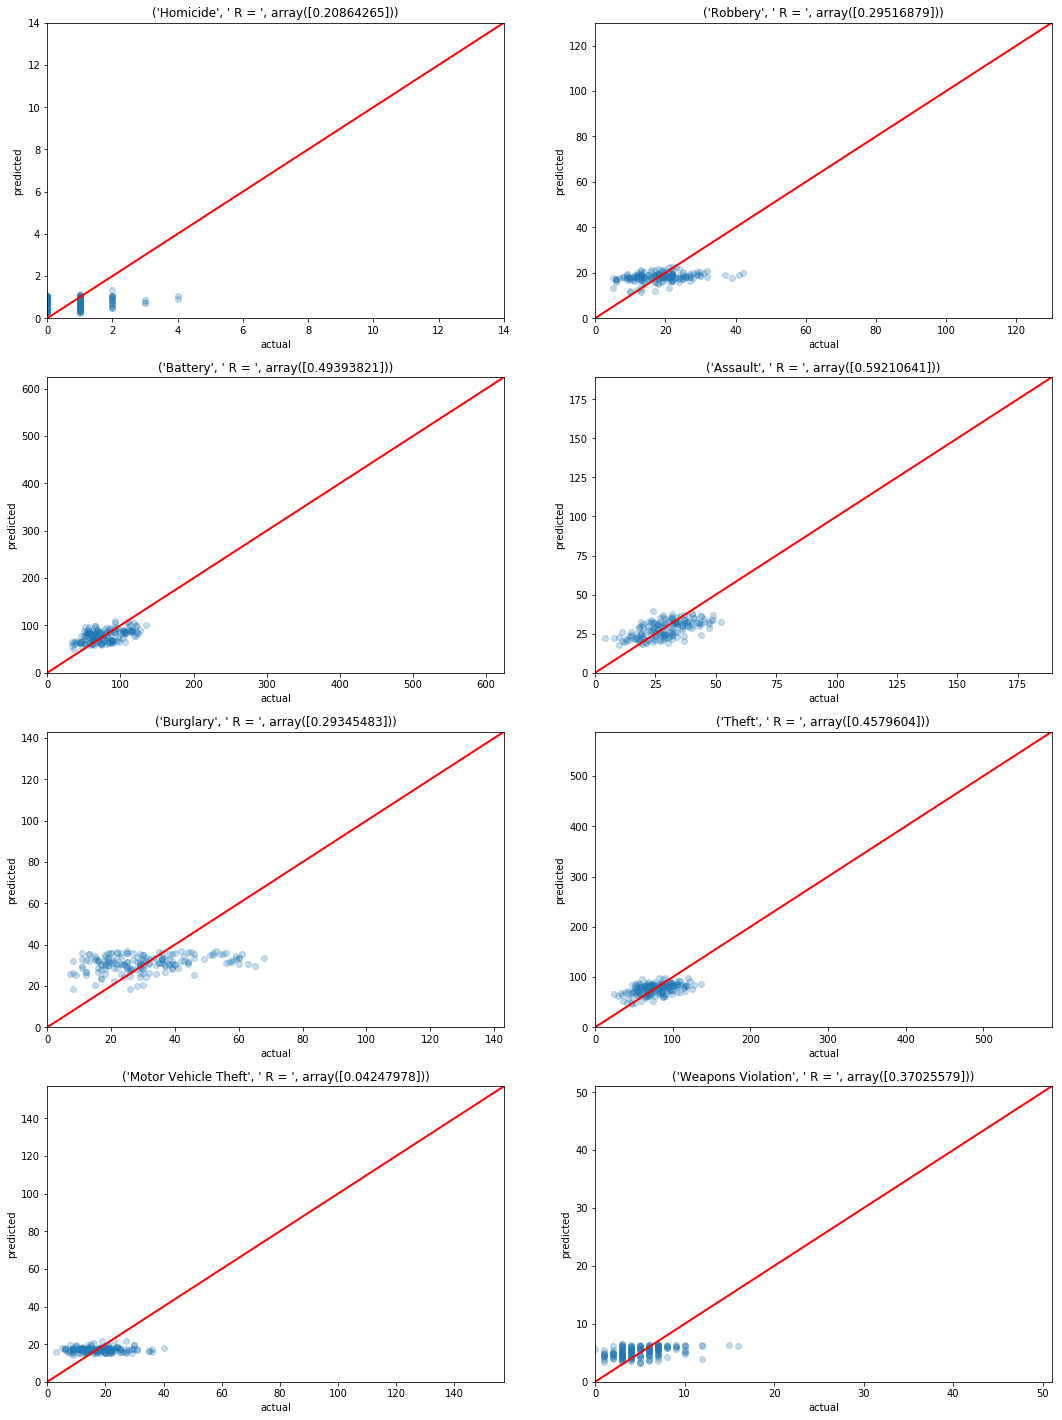

In [155]:
scatterPlotCrimes("8", "5", '1000', Tc8, Ttest, Ytest_8)

# District 9

In [86]:
Xw9, Tc9 = loadWeatherData("wc9.csv", 3)

In [87]:
results = trainNNs(Xw9, Tc9, 0.8, hiddenLayers, 10, 1000)

In [88]:
summarize(results)

[[0, 19.688054933319147, 19.76380482432439, 0.05981326103210449],
 [5, 19.39300607898625, 20.076865960470663, 6.860645771026611],
 [15, 18.995017901905936, 20.09510955724632, 8.041488409042358],
 [[5, 5], 19.13032771896929, 20.119564375434347, 14.285786867141724],
 [[10, 10], 18.475400318283135, 21.069058024641457, 20.57296395301819],
 [[15, 15], 17.91948184145872, 21.627910719415958, 13.782131671905518],
 [[10, 10, 10], 18.13189476883965, 21.650944492365973, 25.648388147354126],
 [[20, 20, 20], 17.530328655705567, 22.31140358646819, 19.425037384033203],
 [[80, 80, 80], 16.222674635001546, 23.358980326097832, 68.7470953464508]]

In [89]:
bestNetwork(summarize(results))

[0, 19.688054933319147, 19.76380482432439, 0.05981326103210449]

In [120]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw9, Tc9, (0.8, 0.2), classify)


nnet_9 = nn.NeuralNetwork(Xw9.shape[1], 5, Tc9.shape[1])
nnet_9.train(Xtrain, Ttrain, 1000)
           
Ytrain_9 = nnet_9.use(Xtrain)
Ytest_9 = nnet_9.use(Xtest)

In [121]:
printCorrelationStats(Ytest_9, Ttest, Tc9, "9")

District  9 : Pearsons Coefficients Actual vs Predicted Data

Homicide 
R =  [0.0927223]  RMSE =  1.4548222683651668 

Robbery 
R =  [0.24636345]  RMSE =  11.130288502185333 

Battery 
R =  [0.52379078]  RMSE =  38.53907647871368 

Assault 
R =  [0.6172922]  RMSE =  14.522459521989118 

Burglary 
R =  [0.17368109]  RMSE =  20.440895791999925 

Theft 
R =  [0.46062747]  RMSE =  28.77373284281171 

Motor Vehicle Theft 
R =  [0.14417221]  RMSE =  11.166468886844717 

Weapons Violation 
R =  [0.45886823]  RMSE =  5.330246770032713 



DISTRICT 9
Hidden Layer Structure: 5, Number Iterations: 1000


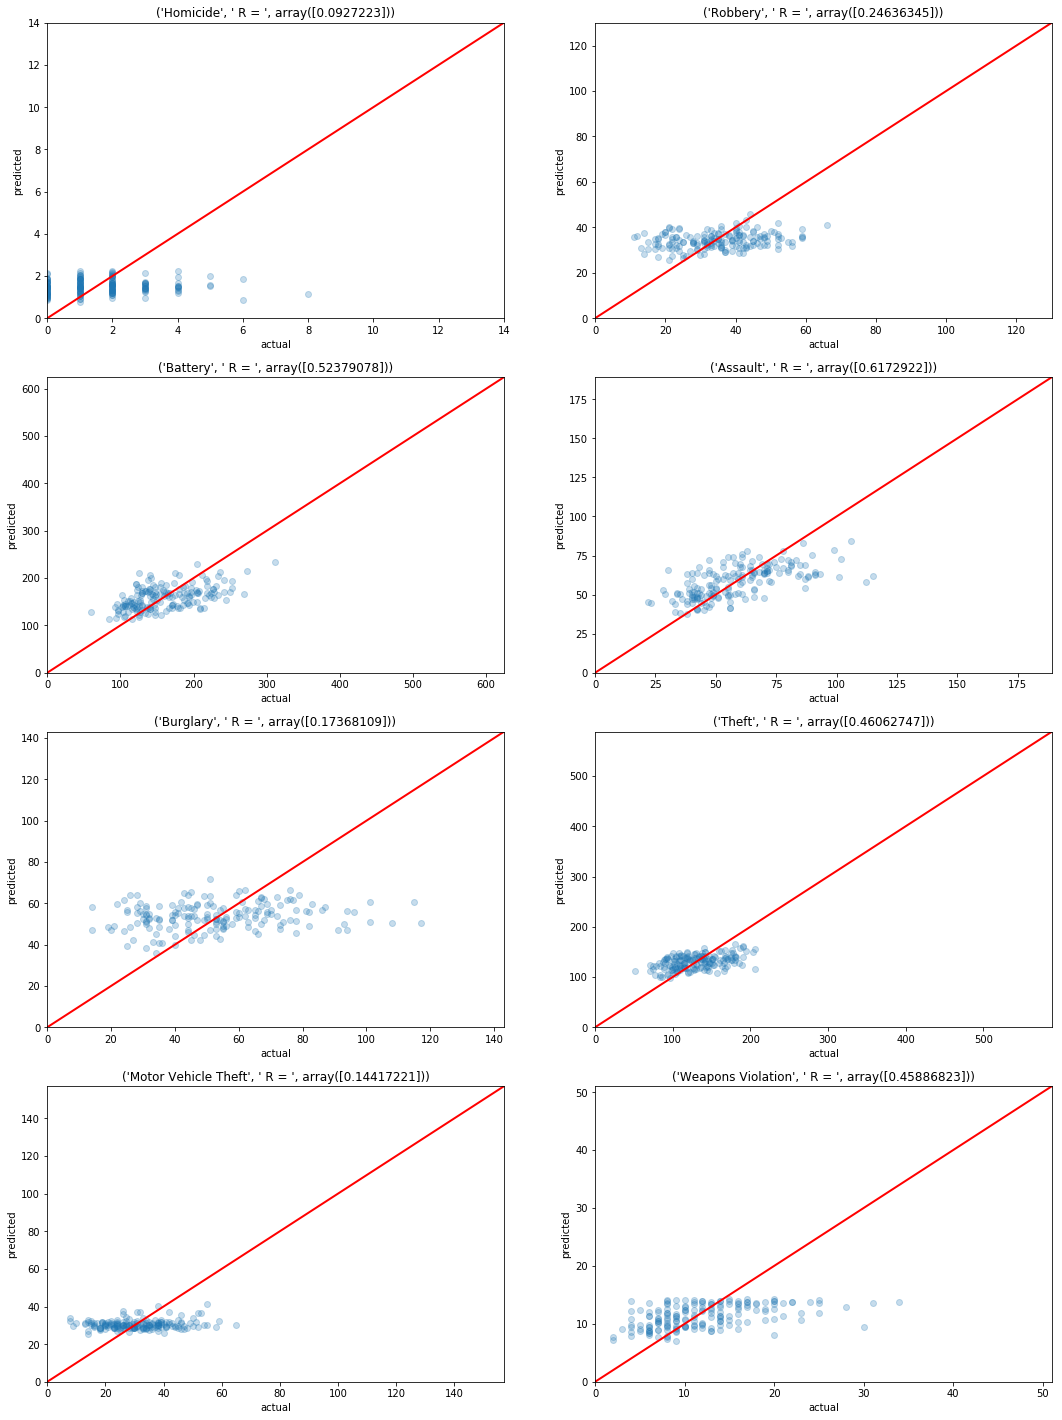

In [122]:
scatterPlotCrimes("9", "5", '1000', Tc9, Ttest, Ytest_9)